Jordi Mestres Esteve

# Damavis Challenge

In [1]:
# import of all the dependencies for the whole notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from catboost import CatBoostRegressor

## 1. Statistical Analysis

### 1.1 Exploratory analysis

After importing the data, the first what should be done is to explore the data and realize clearly what does each field mean and extract some basic information from the dataset like the missing values and other statistical measures.

In [2]:
# downloading the dataset from the source
url = 'https://gist.githubusercontent.com/piffall/1ae5b417d0add7700d8d7fc9f1230642/raw/1e32d34c3bb3cd9bf61de00d5dd00b9c7dab8aaf/surveys.csv'
df = pd.read_csv(url, sep = ',')
df.head()

,overall_satisfaction,room_comfort_satisfaction,room_cleanness_satisfaction,nationality,reception_satisfaction,breakfast_satisfaction,regime,segment,entertainment_satisfaction
0,5.298,5.0,5.0,DE,4.0,4.0,all inclusive,NaN,4.0
1,2.989,3.0,3.0,ES,3.0,4.0,all inclusive,friends,4.0
2,1.910,5.0,5.0,ES,4.0,5.0,all inclusive,NaN,5.0
3,5.964,4.0,4.0,UK,4.0,5.0,all inclusive,family,NaN
4,2.122,5.0,NaN,ES,3.0,5.0,all inclusive,friends,3.0


After seeing for the first time the dataset, we decide to transform the columns 'nationality', 'regime' and 'segment' to categorical variables for further commodity.

In [3]:
# detection of the categorical variables and dtype correction
categorical_vars = ['nationality', 'regime', 'segment']
for var in categorical_vars:
    df[var] = df[var].astype('category')
df.describe()

,overall_satisfaction,room_comfort_satisfaction,room_cleanness_satisfaction,reception_satisfaction,breakfast_satisfaction,entertainment_satisfaction
count,1000.000000,990.000000,949.00000,992.000000,987.000000,711.000000
mean,3.560109,3.904040,3.91254,3.535282,4.959473,3.855134
std,1.537186,1.159601,1.16096,0.781190,0.197291,1.227662
min,-1.002000,1.000000,1.00000,1.000000,4.000000,1.000000
25%,2.464000,3.000000,3.00000,3.000000,5.000000,3.000000
50%,3.184000,4.000000,4.00000,4.000000,5.000000,4.000000
75%,4.964000,5.000000,5.00000,4.000000,5.000000,5.000000
max,6.710000,5.000000,5.00000,5.000000,5.000000,5.000000


In [4]:
# Correction of the min.
# Detected a minimum below the functional documentation specifies
# Procedure: change for the minimum value specified in the documentation
df.loc[df['overall_satisfaction'] < -1, 'overall_satisfaction'] = -1

In [5]:
df[categorical_vars].describe()

,nationality,regime,segment
count,1000,803,696
unique,5,1,4
top,ES,all inclusive,family
freq,487,803,300


In [6]:
df.corr()

,overall_satisfaction,room_comfort_satisfaction,room_cleanness_satisfaction,reception_satisfaction,breakfast_satisfaction,entertainment_satisfaction
overall_satisfaction,1.000000,0.575801,0.584757,0.489763,0.008301,0.019972
room_comfort_satisfaction,0.575801,1.000000,1.000000,0.799198,0.014064,0.077959
room_cleanness_satisfaction,0.584757,1.000000,1.000000,0.795808,0.012139,0.088256
reception_satisfaction,0.489763,0.799198,0.795808,1.000000,0.013354,0.072764
breakfast_satisfaction,0.008301,0.014064,0.012139,0.013354,1.000000,0.023823
entertainment_satisfaction,0.019972,0.077959,0.088256,0.072764,0.023823,1.000000


We may also want to see some plots of the distribution of the overall satisfaction to get an idea about what the variable we and the client want to understand looks like. We also want to look how the variables interact with the others with a correlation analysis. The higher the correlation, the bigger impact is going to make a variable in our focused variable 'overall_satisfaction'.

<AxesSubplot:ylabel='Frequency'>

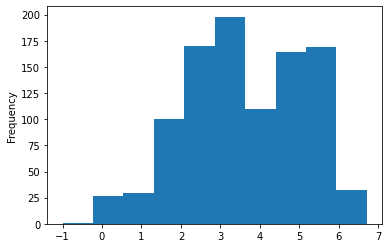

In [7]:
df['overall_satisfaction'].plot(kind='hist')

<AxesSubplot:xlabel='overall_satisfaction'>

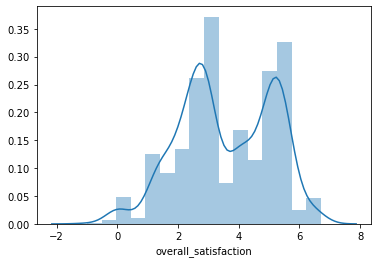

In [8]:
sns.distplot(df['overall_satisfaction'])

At this point and before applying any model, we can see in the numerical variables:
- 'breakfast_satisfaction' does not add much information due de low variability in its values (only 4 and 5) 
- 'entertainment_satisfaction' seems not to be correlated with the final satisfaction of the client. We will keep an eye on it.

These two variables are candidates to be not considered part of the model due to the reasons just exposed.

On the other hand, in the categorical ones we see:
- 'regime' only has or the value 'all inclusive' or a NAN. That is probably a reason to consider removing it.
- 'segment' has an elevated ratio of NAN.

Considering the low amount of records in this dataset we might better consider treating NAN's as a new category as an option the client could not answer for some reason. This is a personal assumption that could be discussed with the team or with the hotel.

### 1.2 Data cleansing

#### 1.2.1 Data imputation

First of all, we have seen that we have nulls and only 1000 observations. At this point, and although that is risky to impute the 30% of a variable, we keep on imputing guided for the low amount of information that we have, the decision is not to waste away the rows that have any missing value. Instead, we will impute the numeric variables with the K-NN method (chosen in this case because we can not have an outlier in discrete numerical punctuation) and for the categorical ones first we will try to use the NAN's as a new category possible.

In [9]:
#imputing the numerical variables
knn = KNNImputer(n_neighbors=5)
numerical = df.drop(categorical_vars, axis=1)
numerical_imputed = pd.DataFrame(knn.fit_transform(numerical), columns=numerical.columns)

#imputing the categorical data with a new category called IMPUTED
df['regime'] = df['regime'].cat.add_categories('IMPUTED').fillna('IMPUTED')
df['segment'] = df['segment'].cat.add_categories('IMPUTED').fillna('IMPUTED')
categorical_imputed = df[categorical_vars]

#### 1.2.2 Normalization

Once we have a dataset with no nulls, we can follow up to the discussion in standarizing and normalizing data. Despite the 'overall_satisfaction', in this case the punctuations between 1 and 5 make most of the variables stable. Moreover, 'overall_satisfaction' has a very uncommon range [-1,7] that will not be ideal to interpret. Reached this point and due the reasoning above the procedure will be to normalize the ranges of all the numeric values into [0-1]. In this case, the decision to not standardize the data is because the ranges of the variables are already defined and we only rescaled them. We will keep a non rescaled dataset just in case we prefer the results without scaling. It will depend on the model used.

In [10]:
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(numerical_imputed), columns=numerical_imputed.columns)

In [11]:
#joining the dataset we just splitted apart
df_model_scaled = pd.concat([scaled,categorical_imputed], axis = 1)
#we may preserve a non scaled dataset in order to have both options
df_model = pd.concat([numerical_imputed,categorical_imputed], axis = 1)
df_model_scaled.head()

,overall_satisfaction,room_comfort_satisfaction,room_cleanness_satisfaction,reception_satisfaction,breakfast_satisfaction,entertainment_satisfaction,nationality,regime,segment
0,0.816861,1.00,1.00,0.75,0.0,0.75,DE,all inclusive,IMPUTED
1,0.517380,0.50,0.50,0.50,0.0,0.75,ES,all inclusive,friends
2,0.377432,1.00,1.00,0.75,1.0,1.00,ES,all inclusive,IMPUTED
3,0.903243,0.75,0.75,0.75,1.0,0.80,UK,all inclusive,family
4,0.404929,1.00,0.85,0.50,1.0,0.50,ES,all inclusive,friends


### 1.3 Re-Explore the dataset

Once we have a dataset to work with, we can plot some boxplots to see how the categories affect in the overall satisfaction. We will do it for the 3 categorical variables.

<AxesSubplot:xlabel='nationality', ylabel='overall_satisfaction'>

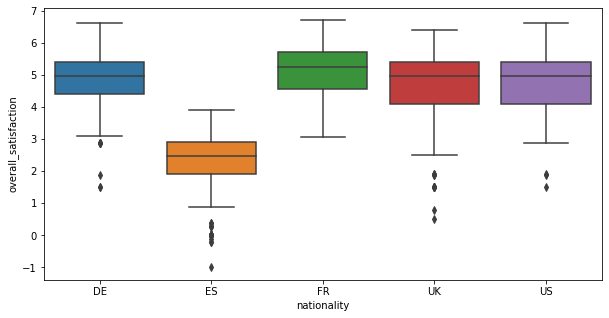

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x='nationality',y='overall_satisfaction', data=df_model)

Here, happened an unexpected result. Spanish people tend to rate significantly worse rather than the other nationalities, so we want to plot, for each nationality all the ratings made by the customers.

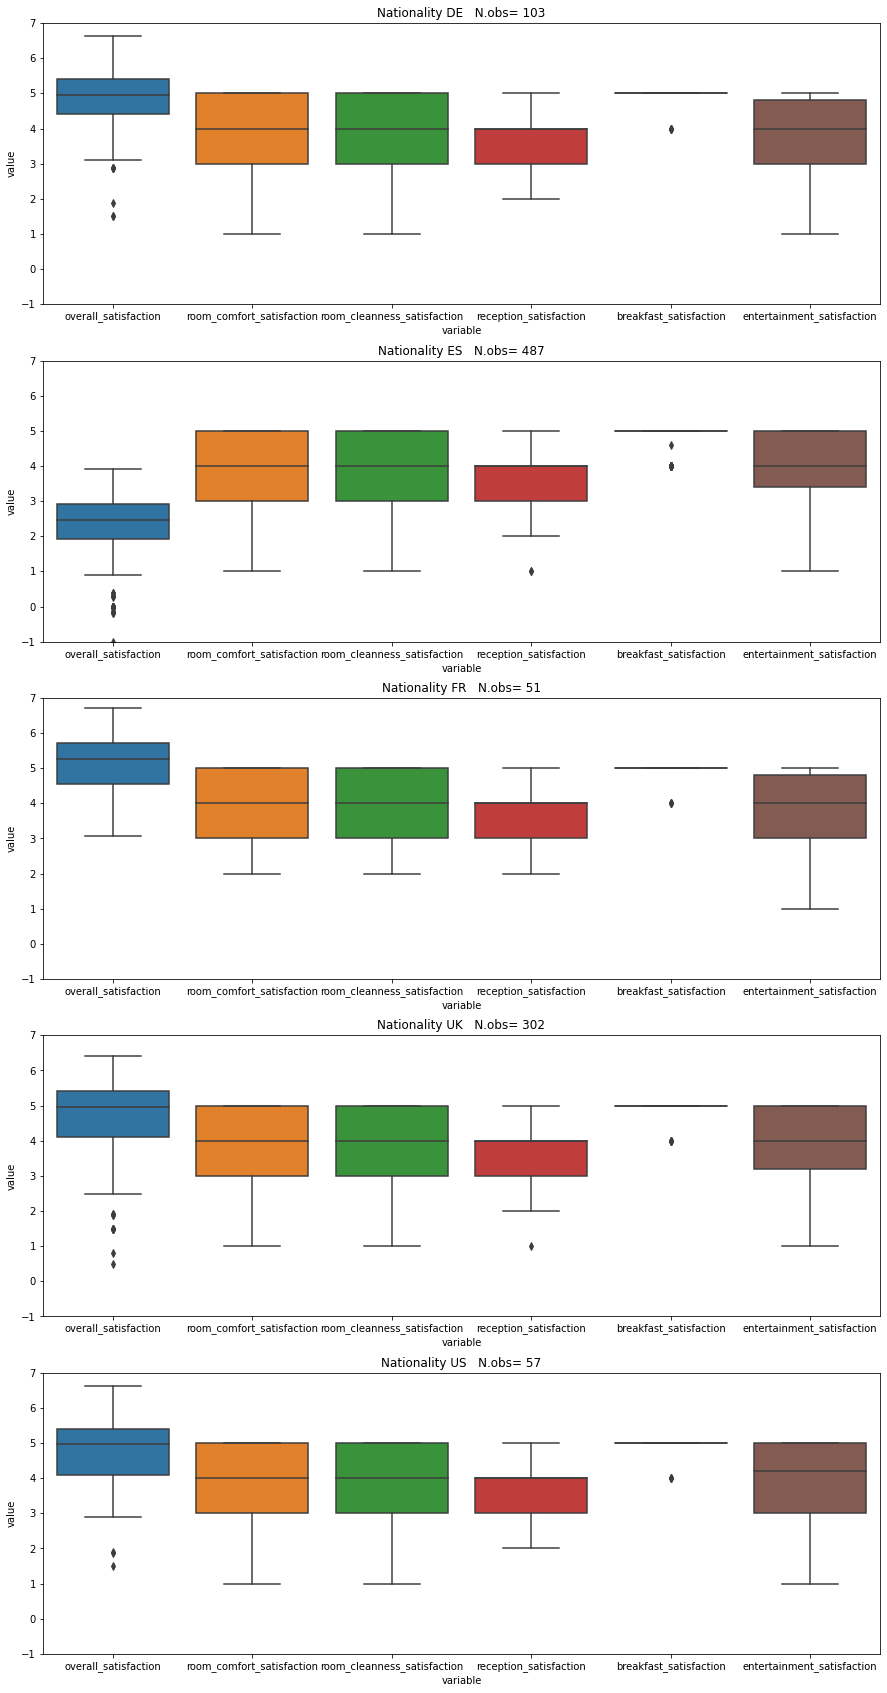

In [34]:
fig, axes = plt.subplots(5,1, figsize=(15,30))

axes = axes.flatten()
i = 0
for nationality, data in df_model.groupby('nationality'):

    title = 'Nationality ' +str(nationality)+ '   N.obs= '+str(len(data))

    sns.boxplot(x='variable', y='value', data=pd.melt(data[numerical.columns]), showfliers=True, ax=axes[i]).set(ylim=(-1,7),title=title)
    i+=1

<AxesSubplot:xlabel='regime', ylabel='overall_satisfaction'>

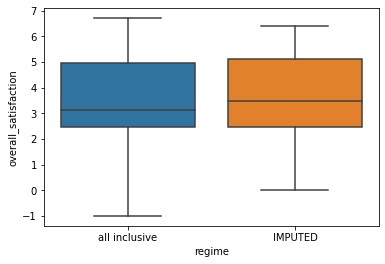

In [14]:
sns.boxplot(x='regime',y='overall_satisfaction', data=df_model )

<AxesSubplot:xlabel='segment', ylabel='overall_satisfaction'>

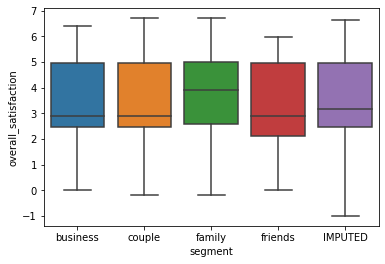

In [15]:
sns.boxplot(x='segment',y='overall_satisfaction', data=df_model )

### 1.4 Modelling

#### 1.4.1 Multivariate analysis with one-hot encoding linear regression

An easy-to-explain model that can ponderate each variable of the dataset in order to fit our data can be this multiple linear regression model that will be able to show which variables affect more and the proportion which they do it.

In [35]:
#note that we use the non rescaled dataset to be able to test the coefficients of the linear regression
dummies = pd.get_dummies(df_model)
# if we were training a model we would remove 1 of the new dummy columns to avoid the multi-collinearity
#dummies.drop(['nationality_US', 'regime_IMPUTED', 'segment_IMPUTED'], axis = 1, inplace=True)

X = dummies.drop(['overall_satisfaction'], axis=1)
Y = dummies['overall_satisfaction']

regr = linear_model.LinearRegression()
regr.fit(X,Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 1.1612336795581375
Coefficients: 
 [-0.64168424  1.22763571  0.19754813  0.00828108  0.0218618   0.44367798
 -1.87351076  0.78508478  0.32415582  0.32059217 -0.03188584  0.03188584
 -0.07098366  0.00475374  0.09494457 -0.02664817 -0.00206648]


In [63]:
coefficients = pd.DataFrame(zip(dummies.drop(['overall_satisfaction'], axis=1).columns, regr.coef_), columns=['feature', 'coefficient'])
coefficients.sort_values(by='coefficient', ascending=False, inplace=True)
coefficients

,feature,coefficient
1,room_cleanness_satisfaction,1.227636
7,nationality_FR,0.785085
5,nationality_DE,0.443678
8,nationality_UK,0.324156
9,nationality_US,0.320592
2,reception_satisfaction,0.197548
14,segment_family,0.094945
11,regime_IMPUTED,0.031886
4,entertainment_satisfaction,0.021862
3,breakfast_satisfaction,0.008281


#### 1.4.2 Variable importance detection with CatBoost

Here, with CatBoost (a suitable modified XGBoost to work well with categories) we can confirm if the weights displayed in the linear regression do align correctly with the variable importance of the model. We can train to predict but it is not the main goal in this problem. We want to ensure and confirm the conclusions seen in the plots and the other model.

In [60]:
params = {'loss_function':'MAE',
          'eval_metric':'MAE',
          'od_type':'IncToDec',
          'learning_rate':0.01,
          'cat_features': categorical_vars,
          'num_trees': 500,
          'verbose':0,
          'random_seed':777,
        }

cb = CatBoostRegressor(**params)

X = df_model_scaled.drop(['overall_satisfaction'], axis=1)
Y = df_model_scaled['overall_satisfaction']

cb.fit(X,Y)

importances = pd.DataFrame(zip(X.columns, cb.get_feature_importance()), columns = ['feature', 'score'])
importances.sort_values(by='score', ascending=False, inplace=True)
importances

,feature,score
5,nationality,74.735540
0,room_comfort_satisfaction,9.726699
1,room_cleanness_satisfaction,8.761832
2,reception_satisfaction,4.360444
4,entertainment_satisfaction,1.277153
7,segment,0.469940
6,regime,0.433744
3,breakfast_satisfaction,0.234648


#### 1.4.3 Variable importance detection without nationality with CatBoost

This point is added due to clarify if any variable does win notoriety when the nationality of the client is not in play.

In [59]:
params = {'loss_function':'MAE',
          'eval_metric':'MAE',
          'od_type':'IncToDec',
          'learning_rate':0.01,
          'cat_features': ['segment', 'regime'],
          'num_trees': 500,
          'verbose':0,
          'random_seed':777,
        }

cb = CatBoostRegressor(**params)

X = df_model_scaled.drop(['overall_satisfaction', 'nationality'], axis=1)
Y = df_model_scaled['overall_satisfaction']

cb.fit(X,Y)

importances = pd.DataFrame(zip(X.columns, cb.get_feature_importance()), columns = ['feature', 'score'])
importances.sort_values(by='score', ascending=False, inplace=True)
importances

,feature,score
1,room_cleanness_satisfaction,26.033942
4,entertainment_satisfaction,23.447531
0,room_comfort_satisfaction,19.987372
6,segment,16.458734
2,reception_satisfaction,7.413228
5,regime,4.458806
3,breakfast_satisfaction,2.200386


## 2. Conclusions

Having in mind that the hotel wants to maximize the overall satisfaction, what we have made in this analysis is finding the most correlated variables which have a direct impact on the overall score. If we check some of the results seen in the whole procedure, we instantly realize that there are variables that do not enrich the data like we mentioned during the process like 'breakfast_satisfaction' which at the end of the analysis we can confirm what we expected having the least importance in CatBoost and the closest value to 0 in the coefficients and that is how we can evaluate the rest of variables.

Considering all the information exposed, a good action plan to improve the overall rate of satisfaction would be:

- **Discover what is happening with the Spanish customers.** Even though they are not rating extremely bad the services of the hotel, they finally set a bad rate to the overall satisfaction so there must be something happening that only affects the Spanish customers.

- **Keep investing in cleaning.** As the cleaning is the most ponderated positively in the coefficients, keeping the hotel clean is a good way to raise the overall satisfaction. Moreover, we see a perfect correlation between cleaning and comfort which does mean that the comfort of the client can be improved directly by the cleaning service and followed up by the reception service.

- **Keep the fantastic breakfast service.** For the analysis is not relevant because it is already outstanding being the greatest service offered by the hotel.

- **Check if the business segment is penalized for some reason.** We see a huge difference between the business segment and the family segment where the first one tends to affect negatively to the overall rating.

- **Revise the survey options.** The high NA values found in certain fields may indicate that some options do not represent the customers when answering the survey and trying to ensure the quality of the data could improve further analysis.